In [44]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
#from astroquery.mast import Observations
import lightkurve
import celerite
from celerite import terms
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table

In [47]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "sans - serif"
rcParams["font.sans-serif"] = ["Verdana"]
rcParams["text.usetex"] = True


Loading in the flare list from 2014

In [4]:
#2014 Flares List

flare_table=pd.read_csv('https://raw.githubusercontent.com/jradavenport/GJ1243-Flares/master/data/gj1243_master_flares.tbl',
            skiprows=23,delim_whitespace=True,names=['index of flare start in "gj1243_master_slc.dat"',
                                                   'index of flare stop in "gj1243_master_slc.dat"','t_start','t_stop'
                                                   ,'t_peak','t_rise','t_decay','flux peak',
                                                   'ED','Duration of rise',
                                                   'Duration of decay','Complex flag',
                                                   '# of people that identified flare event exists',
                                                   '# of people that analyzed this month',
                                                   '# of flare template components fit to event'])
t_starts=flare_table.loc[:,'t_start']
t_stops=flare_table.loc[:,'t_stop']
flux_peak = flare_table.loc[:,'flux peak'].values
complex_flag = flare_table['Complex flag'] #2=complex, 1 = classical
ED = flare_table['ED'] #units=seconds
flare_table['Flare_Duration'] = 1440.*(t_stops-t_starts) #units = minutes

In [5]:
# Separating the types of flares
classical = len([i for i in complex_flag if i < 2.0]) 
print ("The number of classical flares : " + str(classical)) 

cmplx = len([i for i in complex_flag if i > 1.0]) 
print ("The number of complex flares : " + str(cmplx)) 

complex_flares = flare_table[flare_table['Complex flag'] == 2.0]
classical_flares = flare_table[flare_table['Complex flag'] == 1.0]

#-----------------------------------------------------------------------------------------
min_dur = 20.0 #minutes
max_dur = 75.0

dur_limit = len([i for i in flare_table['Flare_Duration'] if i >= min_dur and i<max_dur]) 
print ("The number of total flares with a duration between 20-75min : " + str(dur_limit))

#------------------------------------------------------------------------------------------
#adding in a column that is the flare duration into the table 
classical_flares['Flare_Duration'] = 1440.*(classical_flares['t_stop'] - classical_flares['t_start'])
#classical_flares

print (len([i for i in classical_flares['Flare_Duration'] if i >= min_dur and i < max_dur]))

#------------------------------------------------------------------------------------------

#Table of Classical flares that are between 20-75 minutes as defined in Davenport(2014)

timed_classical = classical_flares[(classical_flares['Flare_Duration'] >= min_dur) & (classical_flares['Flare_Duration'] < max_dur)]
print(len(timed_classical))

The number of classical flares : 5162
The number of complex flares : 945
The number of total flares with a duration between 20-75min : 1641
902
902


/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Importing in the final set of vetted classical flares from Kepler DR 25

In [6]:
kepler_flares =pd.read_csv('/Users/lupitatovar/local_flares/notebooks/flare_diagnostics/final_flare_diagnostics.csv',
            names=["Flare_Number","Type","Notes",'na','key'],skiprows=1)
flag = pd.to_numeric(kepler_flares["Type"].values, errors='coerce')

In [7]:
# FINAL SET OF VETTED KEPLER FLARES

k_classical = len([i for i in flag if i == 1.]) 
print ("The number of remaining classical flares : " + str(k_classical)) 

k_complex = len([i for i in flag if i == 3.]) 
print ("The number flares tossed out : " + str(k_complex)) 

k_edit = len([i for i in flag if i == 2.]) 
print ("The number of flares who need edited times : " + str(k_edit)) 


# Creating the data tables of newly classified flares (use these to make stacked flares plot)
final_edit_times = kepler_flares[kepler_flares["Type"].values == 2.]
final_toss = kepler_flares[kepler_flares["Type"].values == 3.]
final_classic_flares = kepler_flares[kepler_flares["Type"].values == 1.]

#includes flares that need start/stop times edited
keep_flares_final = final_edit_times.combine_first(final_classic_flares)

The number of remaining classical flares : 381
The number flares tossed out : 379
The number of flares who need edited times : 33


In [8]:
#adding index column to Jim's original timed_calssical flares list
timed_classical['Index'] = np.arange(len(timed_classical))
#timed_classical

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
#cross matching the two lists to get new table that has all the flare info!

final_kepler = pd.merge(left=timed_classical, right=keep_flares_final, left_on='Index', right_on='Flare_Number')

In [10]:
len(final_kepler)

414

In [11]:
#saving the 414 flares list table to a .csv that is now on github for public ref
#final_kepler.to_csv('/Users/lupitatovar/local_flares/final_flare_lists/Kepler/gj1243_kepler_classical_flares_list.csv')

Loading in the Kepler light curve for GJ 1243

In [12]:
from lightkurve import search_lightcurvefile
from lightkurve import search_targetpixelfile
target = '9726699'
gj1243_collection = search_lightcurvefile(target,cadence='short').download_all()

gj1243lc = gj1243_collection[0].PDCSAP_FLUX.remove_nans()

#stitching together the full light curve
for q in range(1,len(gj1243_collection)):
    try:
        gj1243lc = gj1243lc.append(gj1243_collection[q].PDCSAP_FLUX).remove_nans()
    except:
            print(q)

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  after removing the cwd from sys.path.
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  # This is added back by InteractiveShellApp.init_path()
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  # This is added back by InteractiveShellApp.init_path()
/Users/lupitatovar/anaco

0 (46806, 7)
1 (42289, 7)
2 (32946, 7)
3 (39984, 7)
4 (44060, 7)
5 (34037, 7)
6 (45254, 7)
7 (39630, 7)
8 (43978, 7)
9 (45006, 7)
10 (39121, 7)


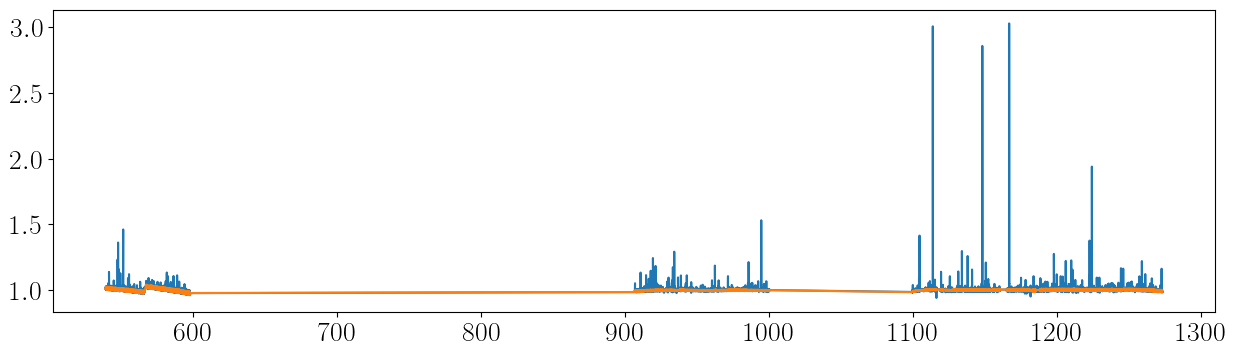

In [13]:
# Importing in GP Info
#Reading in the 11 mo gp files
from glob import glob

kepler_gp_files = glob('*11mo_*.csv')

for k in range(len(kepler_gp_files)): 
    df_tmp = pd.read_csv(kepler_gp_files[k]) 
    print(k, df_tmp.shape) 
    if k==0: 
        df = df_tmp 
    else: 
         df = df.append(df_tmp) 

df = df.sort_values(by='time')

plt.figure(figsize=(15,4))
plt.plot(df['time'], df['detrended_flux'])
plt.plot(df['time'], df['mean'])
plt.show()


Loading in the flare model to fit all of the flares

In [14]:
from scipy import special
def kepler_model(t,tpeak, fwhm, ampl, upsample=False, uptime=10):

    t_new = (t-tpeak)/fwhm +2


    #Values were fit & calculated using MCMC 256 walkers and 10000 steps

    A,B,C,D1,D2,f1 = [3.6281105426668883,1.7500017640073082,0.2035997267409103,1.3548846737678661,0.179091454739574,0.8107078443451485]
    #[18.012482847017512,1.972068713306366,0.044908682424470825,6.536339731685045,0.9387724469269554,0.6183448164959743]
    #[3.714766073353358,1.749665640328046,0.1979131664366433,0.17912992867648345,1.3591276162814818,0.19600454472080225]
    z1 = ((2*B + (C**2 *D1))/(2*C))
    z2 = ((2*B + C**2 *D2)/(2*C))
    f2 = 1-f1
    
    if upsample:
        dt = np.nanmedian(np.diff(np.abs(t_new)))
        timeup = np.linspace(min(t_new)-dt, max(t_new)+dt, t_new.size * uptime)

        flareup = (1/2) * np.sqrt(np.pi) * A * C * ((f1 * np.exp((D1*(B-timeup)) + ((C**2 * D1**2)/4))*(special.erf(z1) - special.erf(z1 - (timeup/C))))
                                                 + (f2 * np.exp((D2*(B-timeup)) + ((C**2 * D2**2)/4))*(special.erf(z2) - special.erf(z2 - (timeup/C)))))

        # and now downsample back to the original time...
        ## this way might be better, but makes assumption of uniform time bins
        # flare = np.nanmean(flareup.reshape(-1, uptime), axis=1)

        ## This way does linear interp. back to any input time grid
        # flare = np.interp(t, timeup, flareup)

        ## this was uses "binned statistic"
        downbins = np.concatenate((t_new-dt/2.,[max(t_new)+dt/2.]))
        flare,_,_ = binned_statistic(timeup, flareup, statistic='mean',bins=downbins)
    else:
        flare = (1/2) * np.sqrt(np.pi) * A * C * ((f1 * np.exp((D1*(B-t_new)) + ((C**2 * D1**2)/4))*(special.erf(z1) - special.erf(z1 - (t_new/C))))
                                             + (f2 * np.exp((D2*(B-t_new)) + ((C**2 * D2**2)/4))*(special.erf(z2) - special.erf(z2 - (t_new/C)))))
        
    erf_bound = 0.5*(special.erf((t_new)*100) + 1)
    
    return flare * ampl * erf_bound 

Loading in the .csv file of the stacked flares from Kepler sample of vetted + aligned flares (new stack procedure results)

In [15]:
fit_flare_vals=pd.read_csv('final_stacked_fits.csv')

Text(0, 0.5, 'Relative Flux')

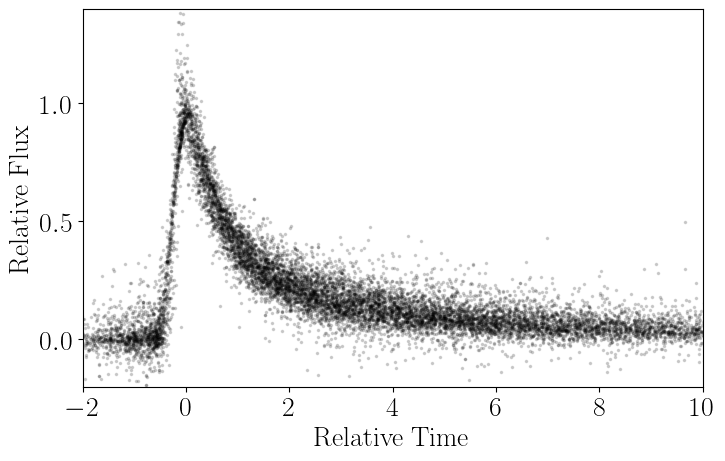

In [16]:
fit_time = fit_flare_vals['time'].values
fit_flux = fit_flare_vals['flux'].values
fit_flux_err = fit_flare_vals['flux_err'].values
fit_gp_err = fit_flare_vals['gp_st_dev'].values

fit_both_errors = np.sqrt( (fit_flux_err)**2 + (fit_gp_err)**2 )

fit_sort = np.argsort(fit_time)
plt.scatter(fit_time[fit_sort],fit_flux[fit_sort],alpha=.15,s=10,marker='.',color='k')
plt.ylim(-0.2,1.4)
plt.xlim(-2,10)
plt.xlabel("Relative Time")
plt.ylabel("Relative Flux")
#plt.savefig('/Users/lupitatovar/flares/figures/kepler_stacked_flares_final.png',bbox_inches='tight')

Flare diagnostics + Model Fits to each one of the classical flares in the Kepler sample

In [17]:
from scipy.optimize import least_squares,curve_fit, minimize

In [18]:
detrended = df['detrended_flux'].values - df['mean'].values
error1 = np.sqrt( (((df['df_flux_err'].values)**2)) + (((df['std'].values)**2)))

In [173]:
#peak_flujo

In [19]:
#coeffs = []
tpeaks = [] 
fwhms = [] 
amps = []

tpeaks_err = []
fwhms_err = []
amps_err = []
#t, tpeak, fwhm, ampl
for i in range (0,len(final_kepler)):

    #taking care of nan_arrays

    t_nan_array = np.isnan(fit_time[fit_sort])
    t_not_nan_array = ~ t_nan_array
    no_nan_time = fit_time[t_not_nan_array]

    no_infs = np.isfinite(no_nan_time)

    #Defining times of each flare event
    i_temp2 = np.where((df['time'].values <= final_kepler['t_stop'].values[i]+0.01) & 
                    (df['time'].values >= final_kepler['t_start'].values[i]-0.005))[0]
    
    peak_flujo = final_kepler['t_stop'].values-final_kepler['t_start'].values
    # arrays to feed into curvefit
    #x_to_fit = no_nan_time[no_infs]
    #y_to_fit = flux[t_not_nan_array][no_infs]
    
    x_fit = df['time'].values[i_temp2]
    y_fit = detrended[i_temp2]


    #defining the error array to feed into curvefit
    #error1 = np.sqrt( (((df['df_flux_err'].values)**2)) + (((df['std'].values)**2)))
    

    #print(error1)
    init_vals= [final_kepler['t_peak'].values[i],peak_flujo[i]/4,final_kepler['flux peak'].values[i]]

    best_vals, covar = curve_fit(kepler_model,x_fit,y_fit, p0=init_vals, maxfev=10000, sigma = error1[i_temp2],
                                  bounds=[[min(x_fit),0,0],[max(x_fit),peak_flujo[i],3*max(y_fit)]])
    
    #absolute_sigma = True
    #print('best_vals: {}'.format(best_vals))
    
    err = np.sqrt(np.diag(covar))
    ############# Saving Output Arrays ################
    tpeaks = np.append(tpeaks,best_vals[0])
    fwhms = np.append(fwhms,best_vals[1])
    amps = np.append(amps,best_vals[2])
    
    tpeaks_err = np.append(tpeaks_err,err[0])
    fwhms_err = np.append(fwhms_err,err[1])
    amps_err = np.append(amps_err,err[2])


In [20]:
print(len(df['time'].values))
print(len(detrended))
print(len(tpeaks))

453111
453111
414


In [147]:
#modeled_flares = pd.DataFrame({'tpeaks':tpeaks, 'fwhms':fwhms, 'amps':amps,
                              #'tpeak_err':tpeaks_err,'fwhms_err':fwhms_err,'amps_err':amps_err})

In [149]:
#modeled_flares.to_csv('/Users/lupitatovar/local_flares/final_flare_lists/Kepler/flares_modeled.csv')

In [140]:
#plt.plot(tpeaks)

In [22]:
''''
for i in range(len(final_kepler)):
    plt.figure(figsize=[12,6])
    #flux_fwhm = np.where(yinterp > half_peaks[i])[0] 
    
    #plt.scatter(tpeaks[i],amps[i],color='red',label='peak',s=50)
    i_temp = np.where((df['time'].values <= final_kepler['t_stop'].values[i]+0.01) & 
                    (df['time'].values >= final_kepler['t_start'].values[i]-0.005))[0]
    
    temp_x_stack = (df['time'].values[i_temp] - tpeaks[i])/(fwhms[i])
    temp_y_stack = ((detrended[i_temp])/(amps[i]))
    #plt.plot(temp_x_stack[i],temp_y_stack[i],color='black')
    #plt.plot(xvals,yinterp,color='black',alpha=0.8,label='interp_data')
    #plt.plot(np.where(xvals,np.where((yinterp > half_peaks[i]))[0],color='black',alpha=0.8,label='interp_data')
    #plt.scatter(xvals[flux_fwhm],yinterp[flux_fwhm], color='red', s=20,label='flux>fwhm',alpha=0.5)

    plt.plot(df['time'],kepler_model(df['time'],tpeaks[i],fwhms[i],amps[i]),color='C0',label='model fit',lw=3)

    plt.plot(df['time'],detrended,color='black',label='flare',alpha=0.5)

    #plt.axhline(y=half_peaks[i], color='green', linestyle='-',label='t_half',alpha=0.7)
    plt.axvline(x=final_kepler['t_start'].values[i], color='green', linestyle='-',alpha=0.7)
    plt.axvline(x=final_kepler['t_stop'].values[i], color='green', linestyle='-',alpha=0.7)
    plt.axvline(x=tpeaks[i], color='purple', linestyle='-')
    

    plt.ylim(-.002,final_kepler['flux peak'].values[i]+.005)
    #plt.xlim(timed_classical['t_start'].values[i]-.1,timed_classical['t_stop'].values[i]+.1)
    plt.xlim(final_kepler['t_start'].values[i]-.005*final_kepler['Flare_Duration'].values[i],final_kepler['t_stop'].values[i]+.005*final_kepler['Flare_Duration'].values[i])
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    plt.title('Flare:'+ str(i))
    plt.xlabel('Time')
    plt.ylabel('Flux')
    plt.savefig('/Users/lupitatovar/local_flares/fit_flares/fits_404_flares'+'flare'+str(i)+'.png',bbox_inches='tight')
    plt.close()
    
'''

"'\nfor i in range(len(final_kepler)):\n    plt.figure(figsize=[12,6])\n    #flux_fwhm = np.where(yinterp > half_peaks[i])[0] \n    \n    #plt.scatter(tpeaks[i],amps[i],color='red',label='peak',s=50)\n    i_temp = np.where((df['time'].values <= final_kepler['t_stop'].values[i]+0.01) & \n                    (df['time'].values >= final_kepler['t_start'].values[i]-0.005))[0]\n    \n    temp_x_stack = (df['time'].values[i_temp] - tpeaks[i])/(fwhms[i])\n    temp_y_stack = ((detrended[i_temp])/(amps[i]))\n    #plt.plot(temp_x_stack[i],temp_y_stack[i],color='black')\n    #plt.plot(xvals,yinterp,color='black',alpha=0.8,label='interp_data')\n    #plt.plot(np.where(xvals,np.where((yinterp > half_peaks[i]))[0],color='black',alpha=0.8,label='interp_data')\n    #plt.scatter(xvals[flux_fwhm],yinterp[flux_fwhm], color='red', s=20,label='flux>fwhm',alpha=0.5)\n\n    plt.plot(df['time'],kepler_model(df['time'],tpeaks[i],fwhms[i],amps[i]),color='C0',label='model fit',lw=3)\n\n    plt.plot(df['time'],det

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


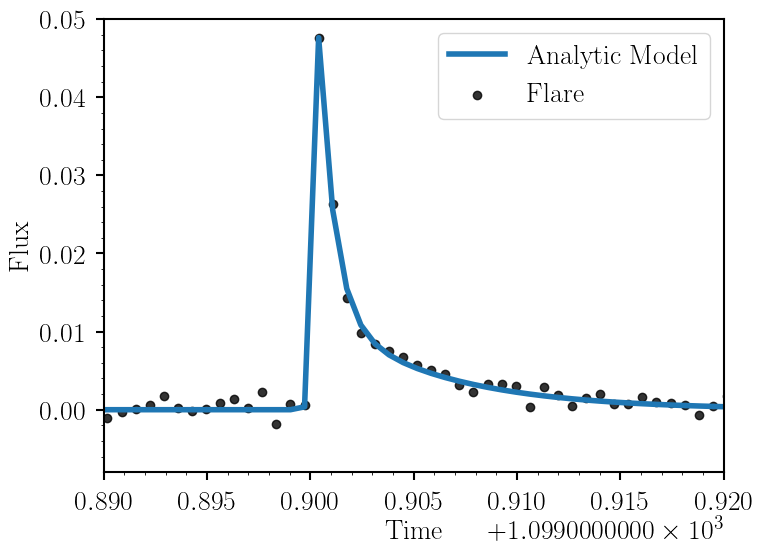

In [23]:
for i in range(1):#len(final_kepler)):
    i=224
    
    #105 has example of the drop off on the rise phase
    
    plt.figure(figsize=[8,6])
    plt.rcParams['axes.linewidth']=1.5
    plt.tick_params(direction='out',width=1.5,length=6,pad=7)
    plt.minorticks_on()
    
    
    #flux_fwhm = np.where(yinterp > half_peaks[i])[0] 
    
    #plt.scatter(tpeaks[i],amps[i],color='red',label='peak',s=50)
    i_temp = np.where((df['time'].values <= final_kepler['t_stop'].values[i]+0.01) & 
                    (df['time'].values >= final_kepler['t_start'].values[i]-0.005))[0]
    
    temp_x_stack = (df['time'].values[i_temp] - tpeaks[i])/(fwhms[i])
    temp_y_stack = ((detrended[i_temp])/(amps[i]))
    #plt.plot(temp_x_stack[i],temp_y_stack[i],color='black')
    #plt.plot(xvals,yinterp,color='black',alpha=0.8,label='interp_data')
    #plt.plot(np.where(xvals,np.where((yinterp > half_peaks[i]))[0],color='black',alpha=0.8,label='interp_data')
    #plt.scatter(xvals[flux_fwhm],yinterp[flux_fwhm], color='red', s=20,label='flux>fwhm',alpha=0.5)

    plt.plot(df['time'],kepler_model(df['time'],tpeaks[i],fwhms[i],amps[i]),color='C0',label='Analytic Model',lw=4)

    plt.scatter(df['time'],detrended,color='black',label='Flare',alpha=0.8)

    #plt.axhline(y=half_peaks[i], color='green', linestyle='-',label='t_half',alpha=0.7)
    #plt.axvline(x=final_kepler['t_start'].values[i], color='green', linestyle='-',alpha=0.7)
    #plt.axvline(x=final_kepler['t_stop'].values[i], color='green', linestyle='-',alpha=0.7)
    #plt.axvline(x=tpeaks[i], color='purple', linestyle='-')
    plt.annotate("",xy=(0.895+1.099e3,0.05), arrowprops=dict(arrowstyle="<->",color='k', lw=5))

    #plt.ylim(-.002,final_kepler['flux peak'].values[i]+.005)
    plt.xlim(-.11+1.1e3,0.92+1.099e3)
    plt.ylim(-0.008,0.05)
    #plt.xlim(timed_classical['t_start'].values[i]-.1,timed_classical['t_stop'].values[i]+.1)
    #plt.xlim(final_kepler['t_start'].values[i]-.005*final_kepler['Flare_Duration'].values[i],final_kepler['t_stop'].values[i]+.005*final_kepler['Flare_Duration'].values[i])
    plt.legend(loc='upper right')
    #plt.title('Flare:'+ str(i))
    plt.xlabel('Time')
    plt.ylabel('Flux')
    #plt.savefig('/Users/lupitatovar/local_flares/paper_figs/annotated_flare.png',bbox_inches='tight')
    #plt.close()

In [24]:
flare_vals = pd.read_csv('/Users/lupitatovar/local_flares/final_flare_lists/Kepler/flares_modeled.csv')

In [25]:
len(flare_vals)

414

### Plotting the Amplitude v FWHM

In [77]:
#plt.scatter(flare_vals['amps'].values,flare_vals['fwhms'].values,c=durations)

In [225]:
#flare_vals['fwhms'].values #units of days
fwhm_min = flare_vals['fwhms'].values * 1440 #units of minutes
fwhm_min_errs = flare_vals['fwhms_err'].values *1440

Text(0, 0.5, 'Flare FWHM')

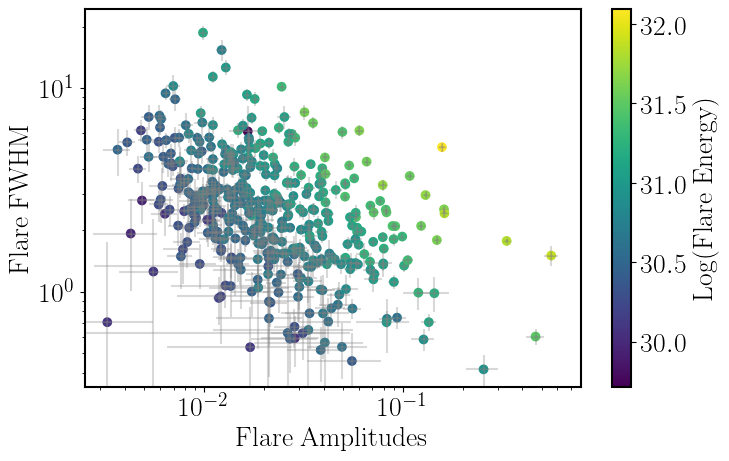

In [226]:
#plt.scatter(flare_vals['amps'].values,flare_vals['fwhms'].values,marker='o',c=energy)
#plt.colorbar()
#plt.scatter(flare_vals['amps'].values,flare_vals['fwhms'].values,marker='o',c=energy)
plt.errorbar(flare_vals['amps'].values,fwhm_min,xerr=flare_vals['amps_err'].values,yerr=fwhm_min_errs,
             linestyle='none',marker='+',color='grey',alpha=0.3)

scatter = plt.scatter(flare_vals['amps'].values,fwhm_min,marker='o',c=energy)

plt.xscale('log')
plt.yscale('log')
#plt.legend(handles=scatter.legend_elements()[0],title="Energies")
plt.colorbar(scatter, label='Log(Flare Energy)')

plt.xlabel('Flare Amplitudes')
plt.ylabel('Flare FWHM')

In [27]:
len(amps)

414

In [28]:
durations = final_kepler['t_stop'].values-final_kepler['t_start'].values
print(len(durations))

414


In [62]:
#durations #in days
durations_min = durations*1440
#print(durations_min)

### Plotting Amplitudes v Durations
Note that our sample uses classical flares with durations from 20-75 min to follow D14

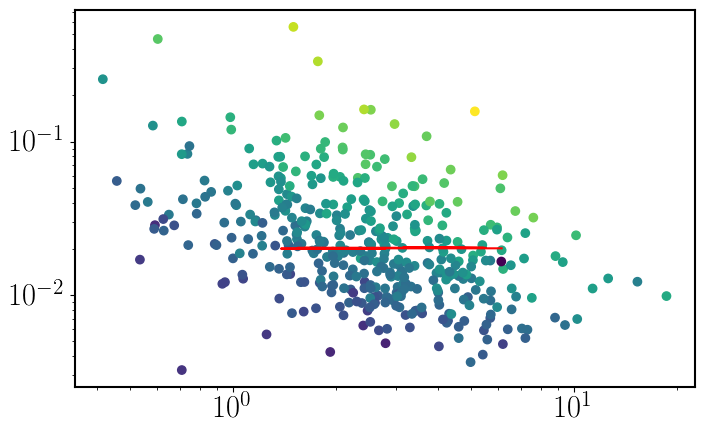

In [386]:
#fitting rolling median
median=pd.Series(flare_vals['amps']).rolling(401).median()

plt.scatter(fwhm_min,flare_vals['amps'].values,c=energy)
plt.plot(fwhm_min,median.values,color='red')
plt.yscale('log')
plt.xscale('log')

In [406]:
from scipy import stats

In [549]:
bin_means, bin_edges, binnumber = stats.binned_statistic((energy),
                (flare_vals['amps'].values), statistic='median', bins=5)

#x_pdf = stats.maxwell.pdf((energy))
#print((bin_edges))

In [562]:
#energy v amp
bin_means, bin_edges, binnumber = stats.binned_statistic((energy),
                (flare_vals['amps'].values), statistic='median', bins=5)

#energy v fwhm
bin_means_fwhm, bin_edges_fwhm, binnumber_fwhm = stats.binned_statistic((energy),
                (fwhm_min), statistic='median', bins=5)

#amp v fwhm
bin_means2, bin_edges2, binnumber2 = stats.binned_statistic((flare_vals['amps'].values),
                (fwhm_min), statistic='median', bins=5)

#energy v dur
bin_means3, bin_edges3, binnumber3 = stats.binned_statistic(energy,
                durations_min, statistic='median', bins=5)

In [655]:
#amps
#bin_means
amp_mid_bin = (bin_edges[:-1]+ bin_edges[1:])/2

#fwhm
#bin_means_fwhm
fwhm_mid_bin = (bin_edges_fwhm[:-1]+ bin_edges_fwhm[1:])/2

print(amp_mid_bin)
print(fwhm_mid_bin)
print(bin_means)
print(bin_means_fwhm)
print(bin_means+bin_means_fwhm/2)

[29.95637411 30.4315175  30.90666089 31.38180427 31.85694766]
[29.95637411 30.4315175  30.90666089 31.38180427 31.85694766]
[0.00713017 0.01137819 0.0232584  0.05255395 0.15934076]
[2.08877176 2.52536148 2.51790573 3.11115951 2.75507798]
[1.05151605 1.27405893 1.28221127 1.6081337  1.53687975]


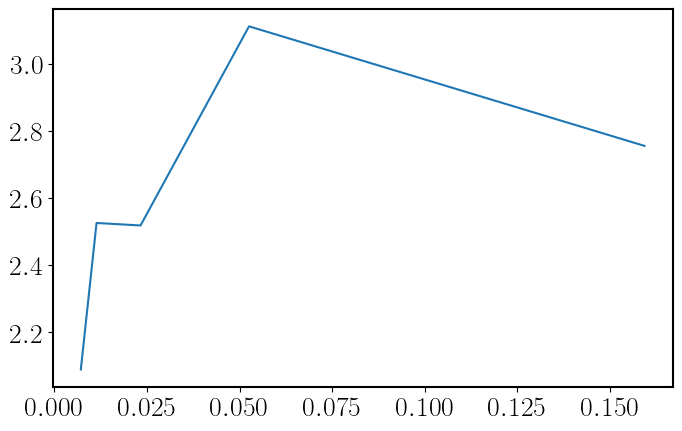

In [662]:

#plt.plot(amp_mid_bin,bin_means+bin_means_fwhm/2)
plt.plot(bin_means,bin_means_fwhm)

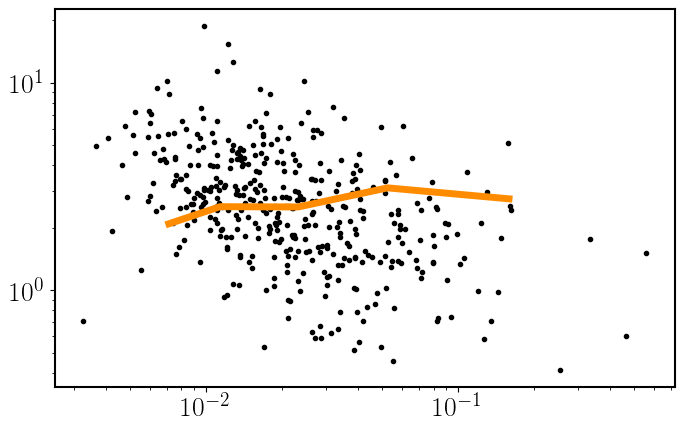

In [664]:
plt.plot(flare_vals['amps'].values,fwhm_min, 'k.', label='raw data')


plt.plot(bin_means,bin_means_fwhm,color='darkorange',lw=5)
plt.xscale('log')
plt.yscale('log')

In [641]:
print(bin_means)
print(bin_edges)
print(np.nanmedian(bin_edges))
print((bin_edges[:-1]+ bin_edges[1:])/2)

[0.00713017 0.01137819 0.0232584  0.05255395 0.15934076]
[29.71880242 30.19394581 30.66908919 31.14423258 31.61937596 32.09451935]
30.906660886046783
[29.95637411 30.4315175  30.90666089 31.38180427 31.85694766]


Text(0, 0.5, 'duration')

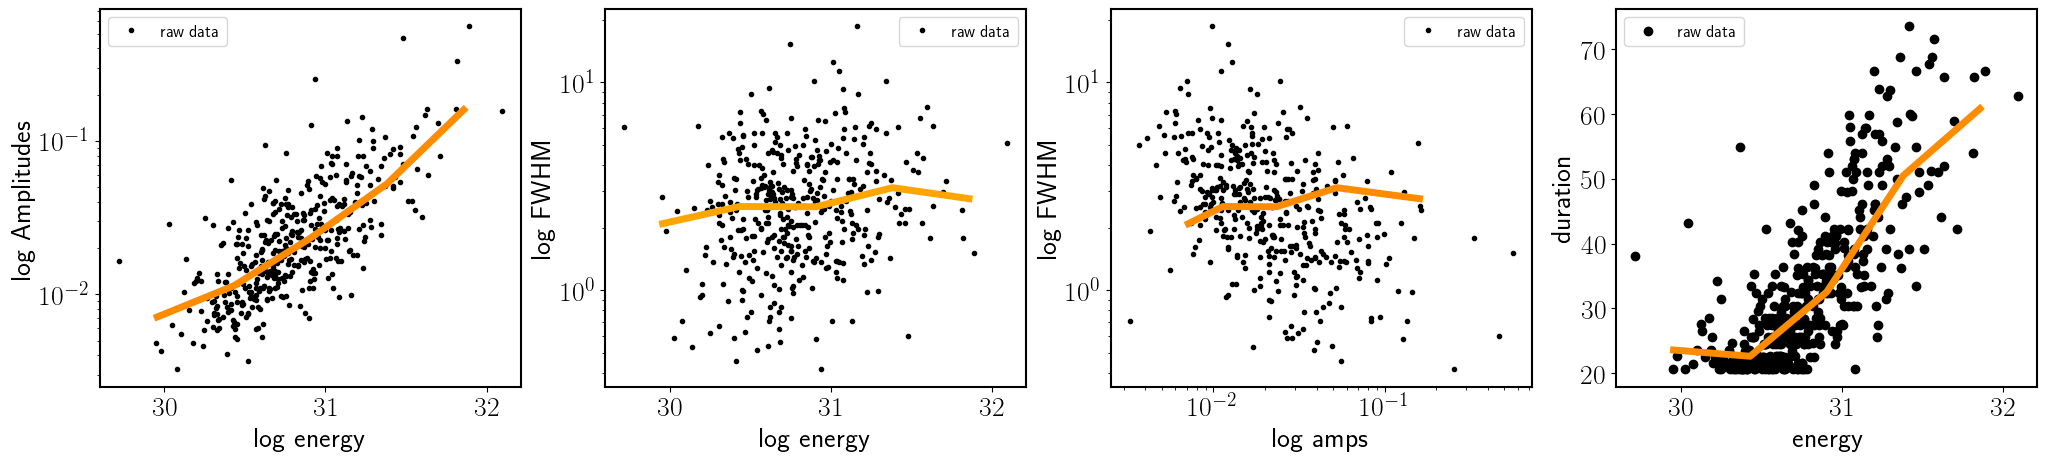

In [665]:
fig,ax =plt.subplots(1,4, figsize=(25, 5), facecolor='w', edgecolor='k')
ax[0].plot(energy,flare_vals['amps'].values, 'k.', label='raw data')
#plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=5,
           #label='binned statistic of data')
#ax[0].plot(bin_edges[:-1],bin_means,color='C0',lw=5) #bin edges
ax[0].plot(((bin_edges[:-1]+ bin_edges[1:])/2),bin_means,color='darkorange',lw=5)
ax[0].legend(fontsize=12)
ax[0].set_xlabel('log energy')
ax[0].set_ylabel('log Amplitudes')
ax[0].set_yscale('log')


ax[1].plot(energy,fwhm_min, 'k.', label='raw data')
#plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=5,
           #label='binned statistic of data')
#ax[1].plot(bin_edges_fwhm[:-1],bin_means_fwhm,color='orange',lw=5) this is just the bin edges
ax[1].plot(((bin_edges_fwhm[:-1]+ bin_edges_fwhm[1:])/2),bin_means_fwhm,color='orange',lw=5)
ax[1].legend(fontsize=12)
ax[1].set_xlabel('log energy')
ax[1].set_ylabel('log FWHM')
ax[1].set_yscale('log')


ax[2].plot(flare_vals['amps'].values,fwhm_min, 'k.', label='raw data')
ax[2].plot(bin_means,bin_means_fwhm,color='darkorange',lw=5)

ax[2].legend(fontsize=12)
ax[2].set_xlabel('log amps')
ax[2].set_ylabel('log FWHM')
ax[2].set_yscale('log')
ax[2].set_xscale('log')

ax[3].scatter(energy,durations_min,color='k', label='raw data')

#ax[3].plot(bin_edges3[:-1],bin_means3,color='C0',lw=5) #just bin edges
ax[3].plot(((bin_edges3[:-1]+ bin_edges3[1:])/2),bin_means3,color='darkorange',lw=5)

ax[3].legend(fontsize=12)
ax[3].set_xlabel('energy')
ax[3].set_ylabel('duration')
#ax[2].set_yscale('log')
#ax[2].set_xscale('log')


#plt.xscale('log')

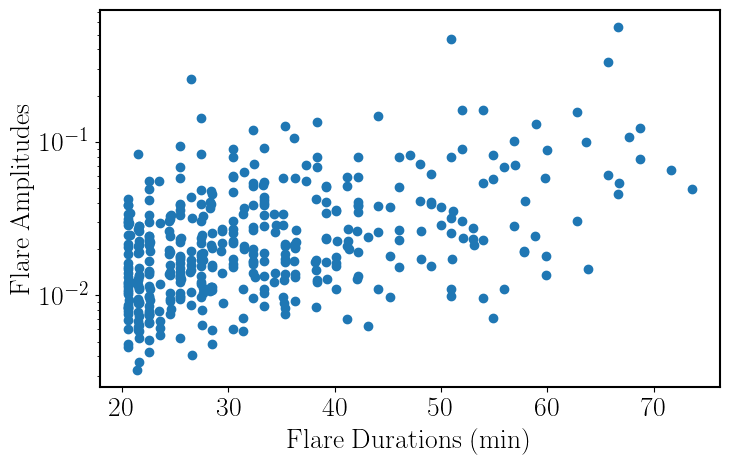

In [31]:
#make amplitude v duration plot HERE
plt.scatter(durations_min,flare_vals['amps'].values,marker='o')
plt.ylabel('Flare Amplitudes')
plt.xlabel('Flare Durations (min)')
#plt.xscale('log')
plt.yscale('log')

### Durations v Energy

In [61]:
#flare equivalent durations + luminosity
Lo= 30.037849 
energy = np.log10(final_kepler['ED'].values) + Lo
#print(energy)

Text(0, 0.5, 'log Flare Energy')

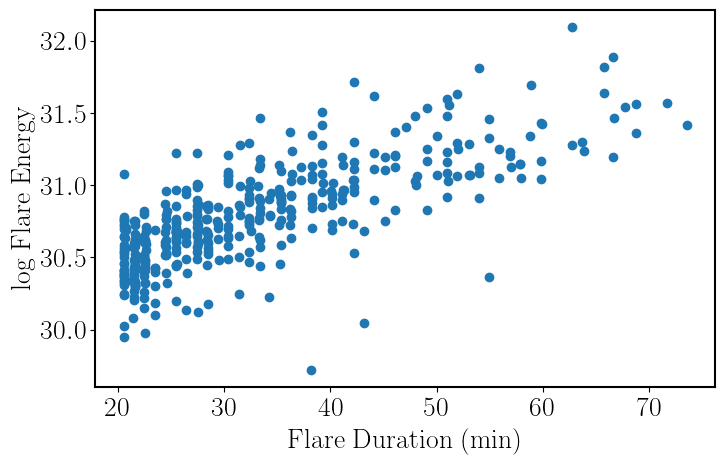

In [33]:
plt.scatter(durations_min,energy,marker='o')
plt.xlabel('Flare Duration (min)')
plt.ylabel('log Flare Energy')
#plt.xscale('log')
#plt.yscale('log')

In [396]:
rcParams["font.size"] = 22
#rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ['Verdana']
rcParams["text.usetex"] = True


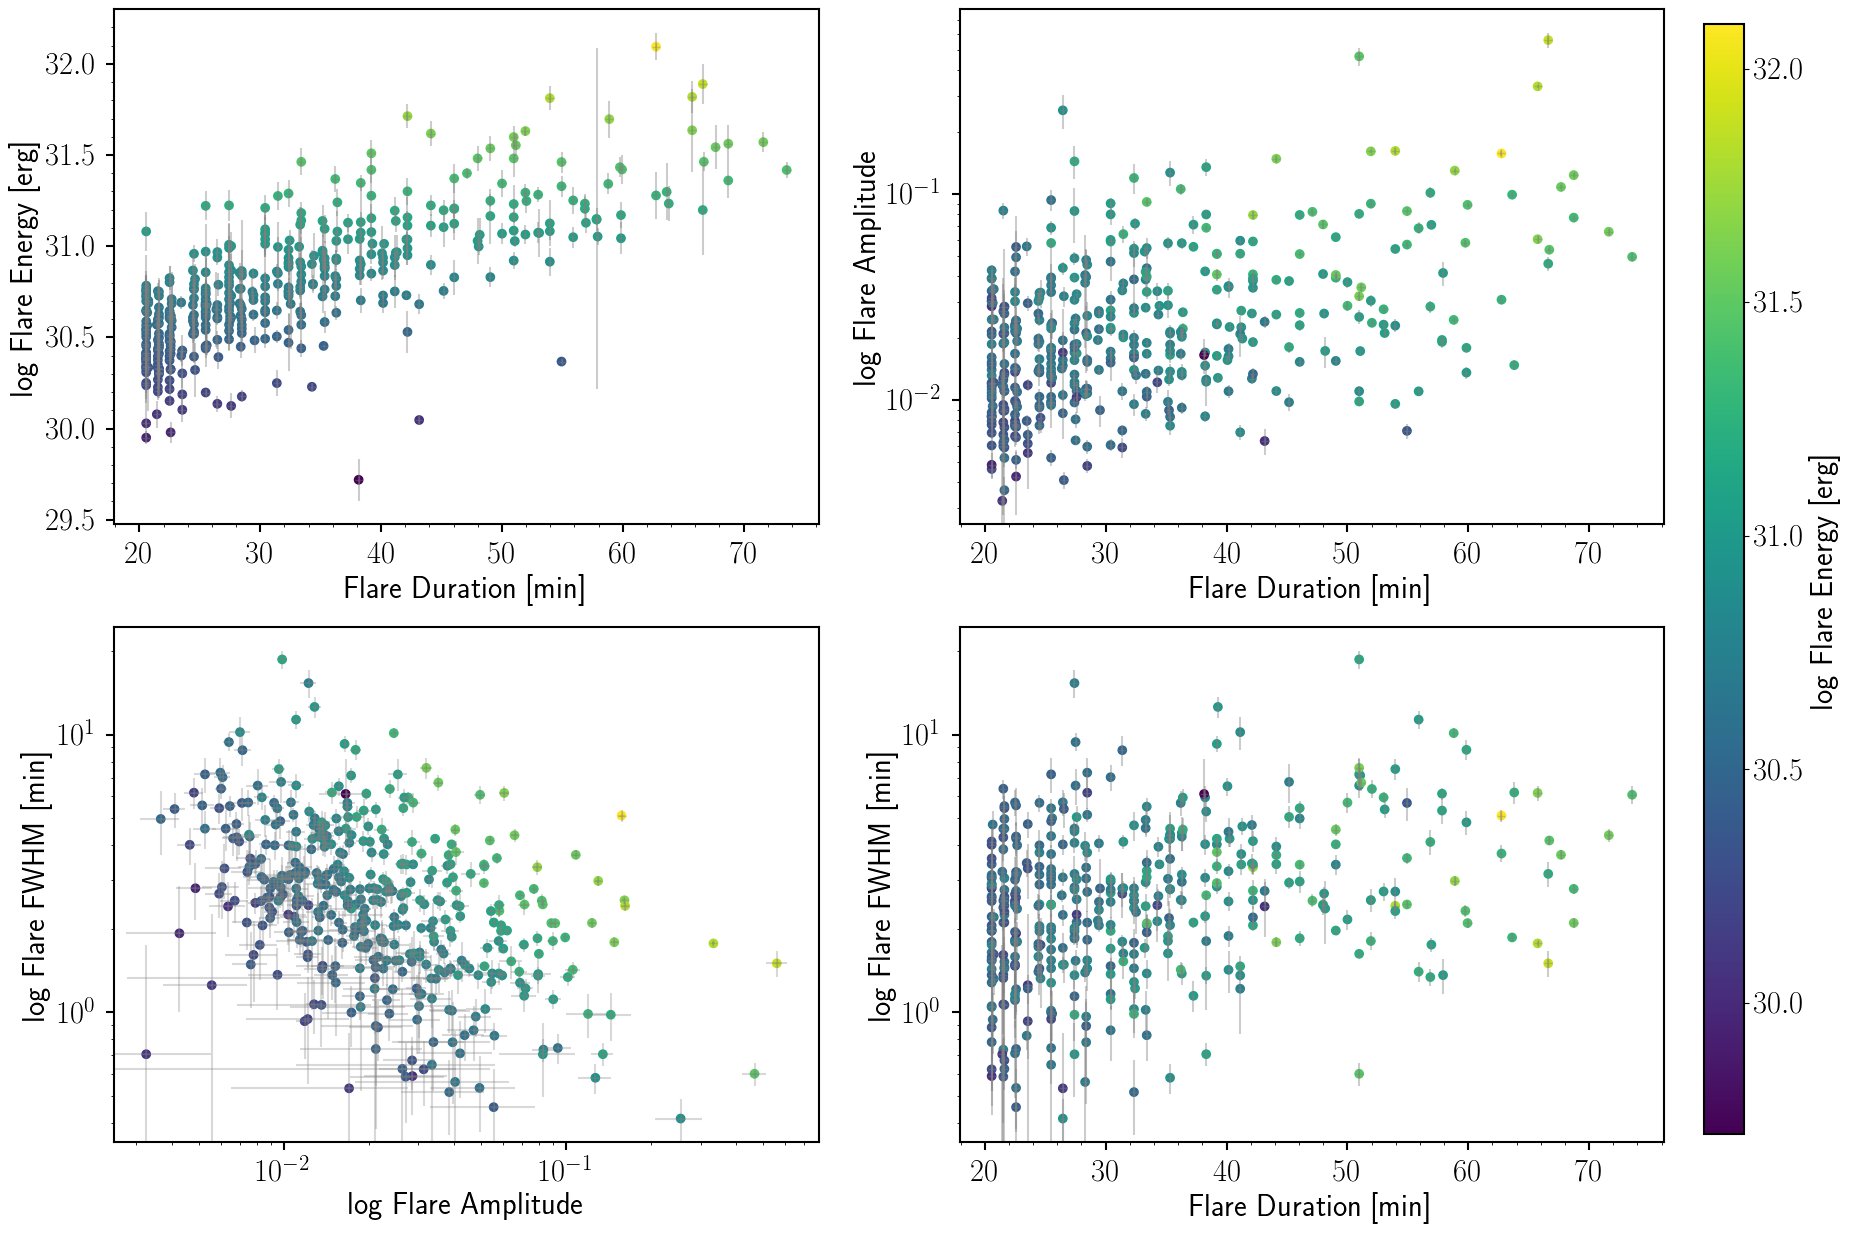

In [401]:
fig, axs = plt.subplots(2,2, figsize=(20, 15), facecolor='w', edgecolor='k')
plt.rcParams['axes.linewidth']=1.5
axs[0,0].tick_params(direction='out',width=1.5,length=6,pad=7)
axs[1,0].tick_params(direction='out',width=1.5,length=6,pad=7)
axs[0,1].tick_params(direction='out',width=1.5,length=6,pad=7)
axs[1,1].tick_params(direction='out',width=1.5,length=6,pad=7)
axs[0,0].minorticks_on()
axs[1,0].minorticks_on()
axs[0,1].minorticks_on()
axs[1,1].minorticks_on() 

#Duration (min) v Energy
axs[0,0].scatter(durations_min,energy,marker='o',c=energy)
axs[0,0].errorbar(durations_min,energy,yerr=xe.values, linestyle='none',marker='+',color='grey',alpha=0.4)
axs[0,0].set_xlabel('Flare Duration [min]')
axs[0,0].set_ylabel('log Flare Energy [erg]')


#Duration (min) v Flare Amps
axs[0,1].scatter(durations_min,flare_vals['amps'].values,marker='o',c=energy)
axs[0,1].errorbar(durations_min,flare_vals['amps'].values,yerr=flare_vals['amps_err'].values, 
                  linestyle='none',marker='+',color='grey',alpha=0.4)
axs[0,1].set_ylabel('log Flare Amplitude')
axs[0,1].set_xlabel('Flare Duration [min]')
axs[0,1].set_yscale('log')

### Flare amps v fwhms
axs[1,0].errorbar(flare_vals['amps'].values,fwhm_min,xerr=flare_vals['amps_err'].values,yerr=fwhm_min_errs,
             linestyle='none',marker='+',color='grey',alpha=0.3)
scatter = axs[1,0].scatter(flare_vals['amps'].values,fwhm_min,marker='o',c=energy)

#axs[1,0].set_colorbar(scatter, label='Log(Flare Energy)')


plt.xlabel('log Flare Amplitude')
plt.ylabel('log Flare FWHM [min]')

axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')

#dur v fwhm
axs[1,1].scatter(durations_min,fwhm_min,marker='o',c=energy)
axs[1,1].errorbar(durations_min,fwhm_min,yerr=fwhm_min_errs, linestyle='none',marker='+',color='grey',alpha=0.4)

#axs[1,0].set_xscale('log')
axs[1,1].set_yscale('log')

axs[1,0].set_xlabel('log Flare Amplitude')
axs[1,0].set_ylabel('log Flare FWHM [min]')

axs[1,1].set_xlabel('Flare Duration [min]')
axs[1,1].set_ylabel('log Flare FWHM [min]')


#### Color map ####
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.13, 0.02, 0.74])
fig.colorbar(scatter, cax=cbar_ax,label='log Flare Energy [erg]')
###### add in error bars where they exist #########

#plt.savefig('/Users/lupitatovar/local_flares/paper_figs/params_duration_errs.png',bbox_inches='tight')

Energy Plots

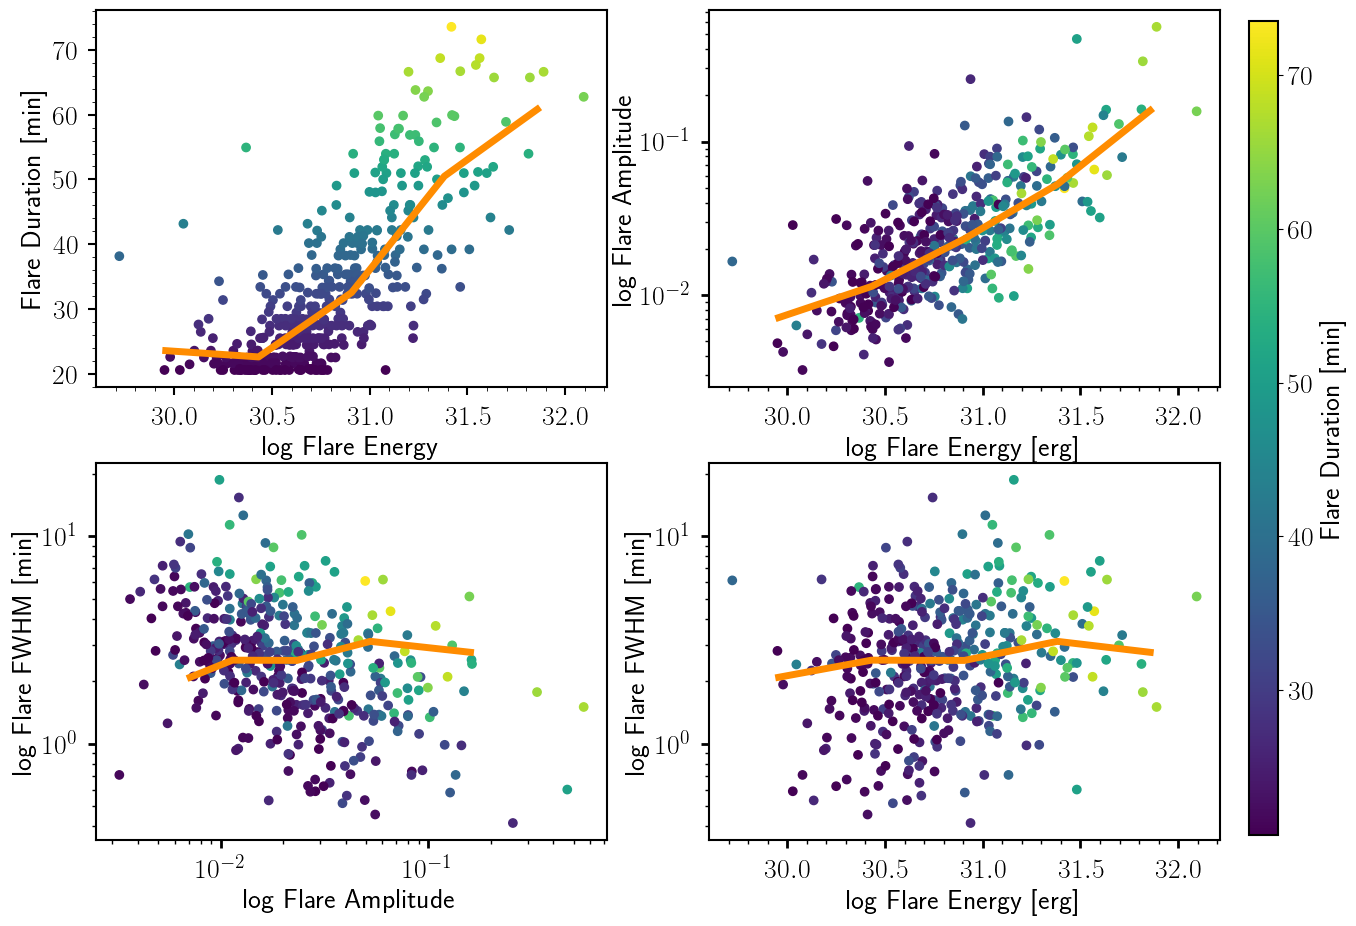

In [667]:
fig, axs = plt.subplots(2,2, figsize=(14.5, 11), facecolor='w', edgecolor='k')
rcParams["font.size"] = 20


#Energy v Duration
axs[0,0].scatter(energy,durations_min,marker='o',c=durations_min)
axs[0,0].plot(((bin_edges3[:-1]+ bin_edges3[1:])/2),bin_means3,color='darkorange',lw=5)
#axs[0,0,].errorbar(energy,durations_min,xerr=xe.values, linestyle='none',marker='+',color='grey',alpha=0.4)
axs[0,0].set_ylabel('Flare Duration [min]')
axs[0,0].set_xlabel('log Flare Energy')


#Energy v Flare Amps
axs[0,1].scatter(energy,flare_vals['amps'].values,marker='o',c=durations_min)
#axs[0,1].errorbar(energy,flare_vals['amps'].values,yerr=amps_err, linestyle='none',marker='+',color='grey',alpha=0.4)
axs[0,1].plot(((bin_edges[:-1]+ bin_edges[1:])/2),bin_means,color='darkorange',lw=5)
axs[0,1].set_ylabel('log Flare Amplitude')
axs[0,1].set_xlabel('log Flare Energy [erg]')
axs[0,1].set_yscale('log')

#Flare amps v fwhms
#axs[1,0].errorbar(flare_vals['amps'].values,fwhm_min,xerr=flare_vals['amps_err'].values,yerr=fwhm_min_errs,
             #linestyle='none',marker='+',alpha=0.4,color='grey')
scatter2 = axs[1,0].scatter(flare_vals['amps'].values,fwhm_min,marker='o',c=durations_min)
#axs[1,0].plot(bin_edges2[:-1],bin_means2,color='darkorange',lw=5)
axs[1,0].plot(bin_means,bin_means_fwhm,color='darkorange',lw=5)
axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')

#energy v fwhm
axs[1,1].scatter(energy,fwhm_min,marker='o',c=durations_min)
axs[1,1].plot(((bin_edges_fwhm[:-1]+ bin_edges_fwhm[1:])/2),bin_means_fwhm,color='darkorange',lw=5)
#axs[1,1].errorbar(energy,fwhm_min,yerr=fwhm_min_errs, linestyle='none',marker='+',color='grey',alpha=0.4)
#axs[1,0].set_xscale('log')
axs[1,1].set_yscale('log')

axs[1,0].set_xlabel('log Flare Amplitude')
axs[1,0].set_ylabel('log Flare FWHM [min]')

axs[1,1].set_xlabel('log Flare Energy [erg]')
axs[1,1].set_ylabel('log Flare FWHM [min]')

#### Color map ####
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.13, 0.02, 0.74])
fig.colorbar(scatter2, cax=cbar_ax,label='Flare Duration [min]')


plt.rcParams['axes.linewidth']=1.5
axs[0,0].tick_params(direction='out',width=1.5,length=6,pad=7)
axs[1,0].tick_params(direction='out',width=2,length=6,pad=7)
axs[0,1].tick_params(direction='out',width=2,length=6,pad=7)
axs[1,1].tick_params(direction='out',width=2,length=6,pad=7)
axs[0,0].minorticks_on()
axs[0,0].tick_params(which='minor', length=3)
axs[0,1].tick_params(which='minor', length=3,width=1)
axs[1,0].tick_params(which='minor', length=3,width=1)
axs[1,1].tick_params(which='minor', length=3,width=1)
axs[1,0].minorticks_on()
axs[0,1].minorticks_on() 
axs[1,1].minorticks_on()

#plt.savefig('/Users/lupitatovar/local_flares/paper_figs/params_energy_median.png',bbox_inches='tight')

Flare Energy vs (amp*fwhm)

These should have a tight correlation! amp * fwhm measures the area of the flare (units of energy) which should correlate to overall flare energy

In [392]:
amp_fwhm = flare_vals['amps'].values * (flare_vals['fwhms'].values * 86400) # 1440 units of minutes *86400 units of sec
#print(amp_fwhm)

In [192]:
Lo

30.037849

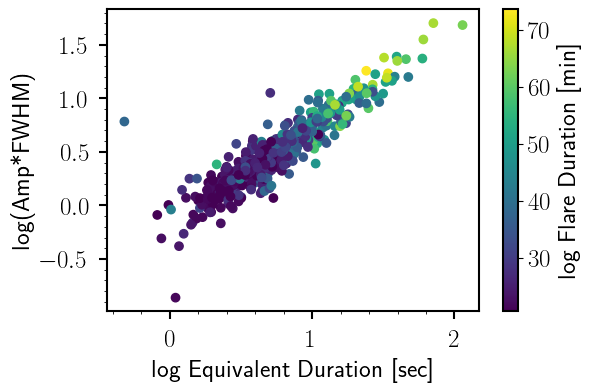

In [608]:
plt.figure(figsize=(6, 4))
rcParams["font.size"] = 18
scatter3=plt.scatter(energy-Lo ,np.log10(amp_fwhm),c=durations_min)
plt.rcParams['axes.linewidth']=1.5
plt.tick_params(direction='out',width=1.5,length=6,pad=7)
plt.minorticks_on()
plt.colorbar(scatter3, label='log Flare Duration [min]')

#plt.yscale('log')
plt.xlabel('log Equivalent Duration [sec]')
plt.ylabel('log(Amp*FWHM)')

#plt.savefig('/Users/lupitatovar/local_flares/paper_figs/energy_v_energy.pdf',bbox_inches='tight')

Calculating Energy Errors

In [160]:
from astropy.modeling.models import Gaussian2D


def FFD(ED, TOTEXP=1., Lum=30., fluxerr=0., dur=[], logY=True, est_comp=False):
    '''
    Given a set of stellar flares, with accompanying durations light curve properties,
    compute the reverse cumulative Flare Frequency Distribution (FFD), and
    approximate uncertainties in both energy and rate (X,Y) dimensions.
    This diagram can be read as measuring the number of flares per day at a
    given energy or larger.
    Not a complicated task, just tedious.
    Y-errors (rate) are computed using Poisson upper-limit approximation from
    Gehrels (1986) "Confidence limits for small numbers of events in astrophysical data", https://doi.org/10.1086/164079
    Eqn 7, assuming S=1.
    X-errors (event energy) are computed following Signal-to-Noise approach commonly
    used for Equivalent Widths in spectroscopy, from
    Vollmann & Eversberg (2006) "Astronomische Nachrichten, Vol.327, Issue 9, p.862", https://dx.doi.org/10.1002/asna.200610645
    Eqn 6.
    Parameters
    ----------
    ED : array of Equiv Dur's, need to include a luminosity!
    TOTEXP : total duration of observations, in days
    Lum : the log luminosity of the star
    fluxerr : the average flux errors of your data (in relative flux units!)
    dur : array of flare durations.
    logY : if True return Y-axis (and error) in log rate (Default: True)
    est_comp : estimate incompleteness using histogram method, scale Y errors?
        (Default: True)
    Returns
    -------
    ffd_x, ffd_y, ffd_xerr, ffd_yerr
    X coordinate always assumed to be log_10(Energy)
    Y coordinate is log_10(N/Day) by default, but optionally is N/Day
    Upgrade Ideas
    -------------
    - More graceful behavior if only an array of flares and a total duration are
        specified (i.e. just enough to make ffd_x, ffd_y)
    - Better propogation of specific flux errors in the light curve, rather than
        average error used
    - Include detrending errors? (e.g. from a GP)
    - Asymmetric Poisson errors?
    - Better handling of incompleteness?
    '''
    # REVERSE sort the flares in energy
    ss = np.argsort(np.array(ED))[::-1]
    ffd_x = np.log10(ED[ss]) + Lum

    Num = np.arange(1, len(ffd_x)+1)
    ffd_y = Num / TOTEXP

    # approximate the Poisson Y errors using Gehrels (1986) eqn 7
    Perror = np.sqrt(Num + 0.75) + 1.0
    ffd_yerr = Perror / TOTEXP

    # estimate completeness using the cumulative distribution of the histogram
    if est_comp:
        # make very loose guess at how many bins to choose
        nbin = int(np.sqrt(len(ffd_x)))
        if nbin < 10:
            nbin=10 # but use at least 10 bins

        # make histogram of the log(energies)
        hh, be = np.histogram(ffd_x, bins=nbin, range=[np.nanmin(ffd_x), np.nanmax(ffd_x)])
        hh = hh/np.nanmax(hh)
        # make cumulative distribution of the histogram, scale to =1 at the hist peak
        cc = np.cumsum(hh)/np.sum(hh[0:np.argmax(hh)])
        be = (be[1:]+be[0:-1])/2
        # make completeness = 1 for energies above the histogram peak
        cc[np.argmax(hh):] = 1
        # interpolate the cumulative histogram curve back to the original energies
        ycomp = np.interp(ffd_x, be, cc)
        # scale the y-errors by the completeness factor (i.e. inflate small energy errors)
        ffd_yerr = ffd_yerr / ycomp

    if logY:
        # transform FFD Y and Y Error into log10
        ffd_yerr = np.abs(ffd_yerr / np.log(10.) / ffd_y)
        ffd_y = np.log10(ffd_y)

    # compute X uncertainties for FFD
    if len(dur)==len(ffd_x):

        # assume relative flux error = 1/SN
        S2N = 1/fluxerr
        # based on Equivalent Width error
        # Eqn 6, Vollmann & Eversberg (2006) Astronomische Nachrichten, Vol.327, Issue 9, p.862
        ED_err = np.sqrt(2)*(dur[ss]*86400. - ED[ss])/S2N
        ffd_xerr = np.abs((ED_err) / np.log(10.) / ED[ss]) # convert to log
    else:
        # not particularly meaningful, but an interesting shape. NOT reccomended
        print('Warning: Durations not set. Making bad assumptions about the FFD X Error!')
        ffd_xerr = (1/np.sqrt(ffd_x-np.nanmin(xT))/(np.nanmax(ffd_x)-np.nanmin(ffd_x)))

    return ffd_x, ffd_y, ffd_xerr, ffd_yerr


def FlareKernel(x, y, xe, ye, Nx=100, Ny=100, xlim=[], ylim=[], return_axis=True):
    '''
    Use 2D Gaussians (from astropy models) to make a basic kernel density,
    with errors in both X and Y considered. Turn into a 2D "image"
    Upgrade Ideas
    -------------
    It's slow. Since Gaussians are defined analytically, maybe this could be
    re-cast as a single array math opperation, and then refactored to have the
    same fit/evaluate behavior as KDE functions.  Hmm...
    '''

    if len(xlim) == 0:
        xlim = [np.nanmin(x) - np.nanmean(xe), np.nanmax(x) + np.nanmean(xe)]
    if len(ylim) == 0:
        ylim = [np.nanmin(y) - np.nanmean(ye), np.nanmax(y) + np.nanmean(ye)]

    xx,yy = np.meshgrid(np.linspace(xlim[0], xlim[1], Nx),
                        np.linspace(ylim[0], ylim[1], Ny), indexing='xy')
    dx = (np.max(xlim)-np.min(xlim)) / (Nx-1)
    dy = (np.max(ylim)-np.min(ylim)) / (Ny-1)

    im = np.zeros_like(xx)

    for k in range(len(x)):
        g = Gaussian2D(amplitude=1/(2*np.pi*(xe[k]+dx)*(ye[k]+dy)),
                       x_mean=x[k], y_mean=y[k], x_stddev=xe[k]+dx, y_stddev=ye[k]+dy)
        tmp = g(xx,yy)
        if np.isfinite(np.sum(tmp)):
            im = im + tmp

    if return_axis:
        return im, xx, yy
    else:
        return im

In [162]:
final_kepler

,"index of flare start in ""gj1243_master_slc.dat""","index of flare stop in ""gj1243_master_slc.dat""",t_start,t_stop,t_peak,t_rise,t_decay,flux peak,ED,Duration of rise,...,# of people that identified flare event exists,# of people that analyzed this month,# of flare template components fit to event,Flare_Duration,Index,Flare_Number,Type,Notes,na,key
0,275.0,310.0,539.646668,539.671143,539.650024,0.003357,0.021118,0.005733,2.601320,0.291359,...,8.0,8.0,2.0,35.244144,0,0.0,1.0,NaN,NaN,NaN
1,594.0,614.0,539.865967,539.880249,539.870056,0.004089,0.010193,0.004795,0.978497,0.187819,...,8.0,8.0,1.0,20.566368,1,1.0,1.0,Peak marked higher than interp_data,NaN,NaN
2,2438.0,2459.0,541.142456,541.156738,541.144470,0.002014,0.012268,0.006591,2.378301,0.567651,...,8.0,8.0,1.0,20.566368,5,5.0,1.0,NaN,NaN,NaN
3,2475.0,2517.0,541.167664,541.196899,541.173096,0.005432,0.023804,0.010578,4.931096,1.413226,...,8.0,8.0,1.0,42.099552,6,6.0,1.0,NaN,NaN,NaN
4,2565.0,2587.0,541.229614,541.245300,541.232361,0.002747,0.012939,0.005510,1.937838,0.650844,...,8.0,8.0,1.0,22.587840,7,7.0,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,429418.0,429438.0,1269.798706,1269.812988,1269.800049,0.001343,0.012939,0.006751,2.598324,0.352676,...,5.0,5.0,1.0,20.566368,893,893.0,1.0,NaN,NaN,NaN
410,432110.0,432143.0,1271.654785,1271.677368,1271.656860,0.002075,0.020508,0.012393,4.421083,0.366998,...,5.0,5.0,2.0,32.519520,895,895.0,1.0,NaN,NaN,NaN
411,432246.0,432279.0,1271.747437,1271.770630,1271.750855,0.003418,0.019775,0.021546,7.094260,1.386822,...,5.0,5.0,1.0,33.398496,896,896.0,1.0,NaN,NaN,NaN
412,432724.0,432752.0,1272.074463,1272.093506,1272.076416,0.001953,0.017090,0.026030,6.193323,0.800871,...,5.0,5.0,1.0,27.421920,898,898.0,1.0,NaN,NaN,NaN


In [163]:
np.nanmedian(np.diff(gj1243lc.time.value))*len(gj1243lc)

333.3958792749254

In [166]:
x,y,xe,ye = FFD(final_kepler['ED'], dur=final_kepler['t_stop']-final_kepler['t_start'], Lum=30.037849 ,TOTEXP=333.3958792,
                fluxerr=np.median(gj1243lc.flux_err.value)/np.median(gj1243lc.flux.value))

im, xx, yy = FlareKernel(x,y,xe,ye)

#energy error bars
print(xe.values)
#plt.plot(x,y,'-o',label='Jim FFD')
#plt.plot(tess_x_ffd,tess_y_ffd,'-o', color='purple', alpha=0.5,label='classical tess flares')
#plt.plot(all_tess_x_ffd,all_tess_y_ffd,'-o', color='orange', alpha=0.5,label="all tess flares")

#plt.errorbar(x,y, xerr=xe, yerr=ye)
#plt.contour(xx, yy, im)
#plt.xlabel('log Energy (erg)')
#plt.ylabel('log Flare Rate (day$^{-1}$)')
#plt.legend()

[0.00628557 0.01083589 0.01260224 0.01047913 0.01028278 0.01499332
 0.01932479 0.01538087 0.01346171 0.01629183 0.02451168 0.02398645
 0.01815227 0.02469274 0.01810854 0.01537464 0.02013001 0.02140544
 0.0292848  0.0145768  0.02416755 0.0281088  0.0290011  0.01899111
 0.03588863 0.02387689 0.02494432 0.01969703 0.03828556 0.02192907
 0.02889117 0.03418326 0.03288412 0.02690409 0.040938   0.03371326
 0.02113873 0.03530619 0.04224663 0.02639841 0.02122115 0.04005093
 0.03529997 0.03756872 0.02665336 0.04760469 0.04245385 0.0382347
 0.02083197 0.03364508 0.01945656 0.02386656 0.03646614 0.04530226
 0.03672243 0.05397536 0.03664407 0.03352091 0.02799528 0.05168469
 0.04283594 0.04515554 0.03744436 0.03514007 0.05241182 0.05292226
 0.03080592 0.0326151  0.03829631 0.03611009 0.03536921 0.05420683
 0.0517452  0.04432074 0.03238728 0.04153648 0.04347281 0.04543177
 0.03621921 0.0313518  0.05356728 0.05711428 0.02171437 0.03864661
 0.04190931 0.04126145 0.05718187 0.05743274 0.03281966 0.05463

Text(0, 0.5, 'Flare rate per day')

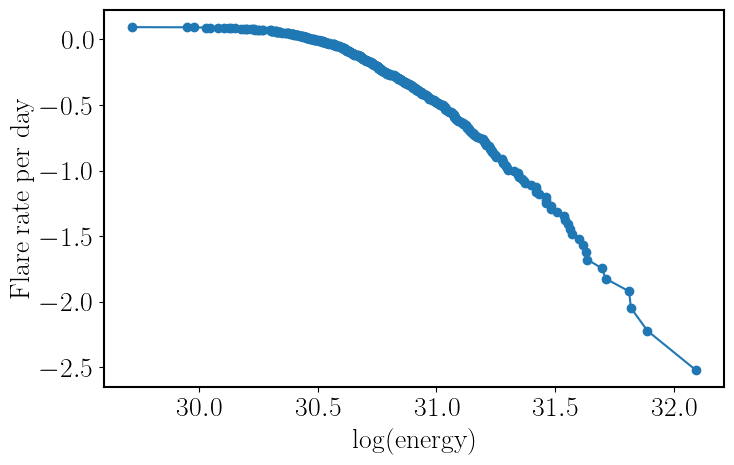

In [176]:
plt.plot(x,y,'-o',label='Jim FFD')
plt.xlabel('log(energy)')
plt.ylabel('Flare rate per day')

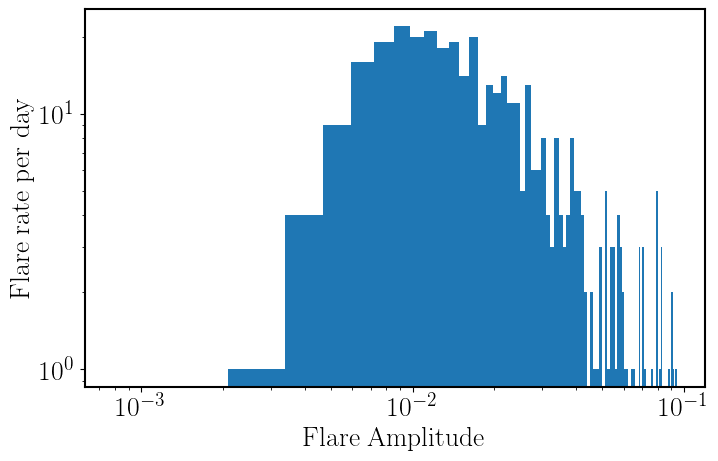

In [190]:
plt.hist(flare_vals['amps'].values,y,histtype='bar')
plt.xlabel('Flare Amplitude')
plt.ylabel('Flare rate per day')
plt.xscale('log')
plt.yscale('log')

Energy plots with error bars

Text(0, 0.5, 'Flare FWHM')

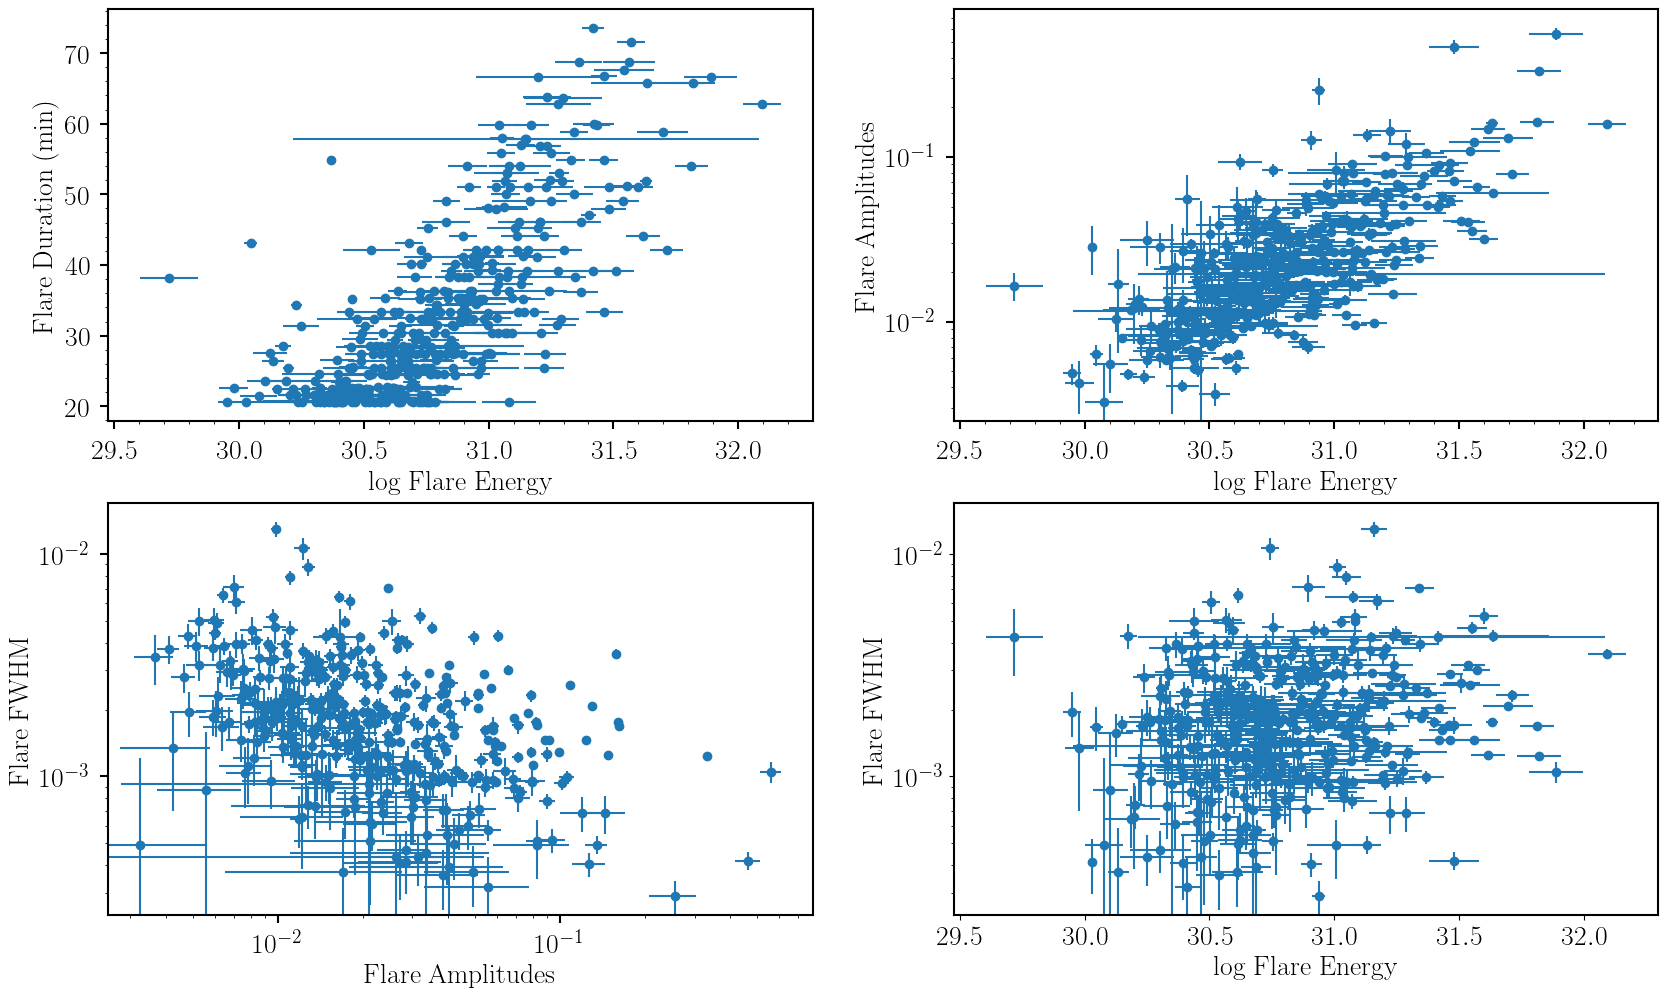

In [170]:
fig, axs = plt.subplots(2,2, figsize=(20, 12), facecolor='w', edgecolor='k')
plt.rcParams['axes.linewidth']=1.5
axs[0,0].tick_params(direction='out',width=1.5,length=6,pad=7)
axs[1,0].tick_params(direction='out',width=1.5,length=6,pad=7)
axs[0,1].tick_params(direction='out',width=1.5,length=6,pad=7)
axs[0,0].minorticks_on()
axs[1,0].minorticks_on()
axs[0,1].minorticks_on() 

#Energy v Duration
axs[0,0].errorbar(energy,durations_min,xerr=xe.values,marker='o',linestyle='none')
axs[0,0].set_ylabel('Flare Duration (min)')
axs[0,0].set_xlabel('log Flare Energy')


#Energy v Flare Amps
axs[0,1].errorbar(energy,flare_vals['amps'].values,xerr=xe.values,yerr=flare_vals['amps_err'].values,marker='o'
                 ,linestyle='none')
axs[0,1].set_ylabel('Flare Amplitudes')
axs[0,1].set_xlabel('log Flare Energy')
axs[0,1].set_yscale('log')

#Flare amps v fwhms
axs[1,0].errorbar(flare_vals['amps'].values,flare_vals['fwhms'].values,xerr=flare_vals['amps_err'].values,yerr=flare_vals['fwhms_err'].values,
             linestyle='none',marker='o')
#scatter2 = axs[1,0].scatter(flare_vals['amps'].values,flare_vals['fwhms'].values,marker='o',c=durations_min)
axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')

#energy v fwhm
axs[1,1].errorbar(energy,flare_vals['fwhms'].values,xerr=xe.values,yerr=flare_vals['fwhms_err'].values,marker='o',linestyle='none')
#axs[1,0].set_xscale('log'
axs[1,1].set_yscale('log')

axs[1,0].set_xlabel('Flare Amplitudes')
axs[1,0].set_ylabel('Flare FWHM')

axs[1,1].set_xlabel('log Flare Energy')
axs[1,1].set_ylabel('Flare FWHM')

#### Color map ####
#fig.subplots_adjust(right=0.9)
#cbar_ax = fig.add_axes([0.92, 0.13, 0.02, 0.74])
#fig.colorbar(scatter2, cax=cbar_ax,label='Flare Duration (min)')


###### add in error bars where they exist #########